In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense

In [2]:
df = pd.read_pickle('datasetFER.pkl')

In [3]:
df.head()

,Imagen,Imagen con zoom,Hitos faciales,Etiquetas
0,"[[127, 127, 125, 123, 121, 122, 123, 124, 127,...","[[127, 127, 125, 123, 121, 122, 123, 124, 127,...","[[18, 37], [18, 51], [18, 66], [21, 81], [27, ...",angry
1,"[[248, 248, 246, 245, 243, 246, 249, 253, 254,...","[[248, 248, 246, 245, 243, 246, 249, 253, 254,...","[[-6, 42], [-7, 63], [-5, 84], [-2, 104], [6, ...",angry
2,"[[225, 225, 226, 228, 230, 230, 230, 230, 230,...","[[210, 206, 208, 211, 214, 215, 216, 217, 216,...","[[35, 56], [35, 65], [36, 74], [39, 83], [42, ...",angry
3,"[[118, 118, 86, 52, 18, 13, 15, 16, 16, 14, 13...","[[65, 78, 90, 102, 110, 117, 125, 129, 133, 13...","[[35, 86], [38, 98], [44, 109], [53, 118], [62...",angry
4,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[37, 34], [34, 49], [33, 64], [35, 80], [39, ...",angry


In [21]:
print(df['Hitos faciales'][0])

[array([18, 37]), array([18, 51]), array([18, 66]), array([21, 81]), array([27, 95]), array([ 33, 109]), array([ 40, 121]), array([ 46, 131]), array([ 57, 134]), array([ 72, 131]), array([ 87, 122]), array([102, 111]), array([115,  98]), array([125,  83]), array([129,  65]), array([131,  46]), array([132,  27]), array([17, 25]), array([21, 20]), array([29, 17]), array([37, 17]), array([45, 22]), array([58, 21]), array([68, 15]), array([79, 15]), array([91, 18]), array([100,  23]), array([50, 32]), array([48, 42]), array([46, 53]), array([44, 64]), array([39, 72]), array([43, 75]), array([49, 77]), array([57, 73]), array([63, 68]), array([26, 35]), array([31, 32]), array([37, 32]), array([43, 35]), array([37, 36]), array([31, 37]), array([68, 33]), array([74, 29]), array([81, 29]), array([88, 31]), array([81, 33]), array([75, 33]), array([36, 94]), array([40, 91]), array([47, 89]), array([53, 90]), array([59, 87]), array([70, 86]), array([82, 88]), array([79, 89]), array([59, 89]), arra

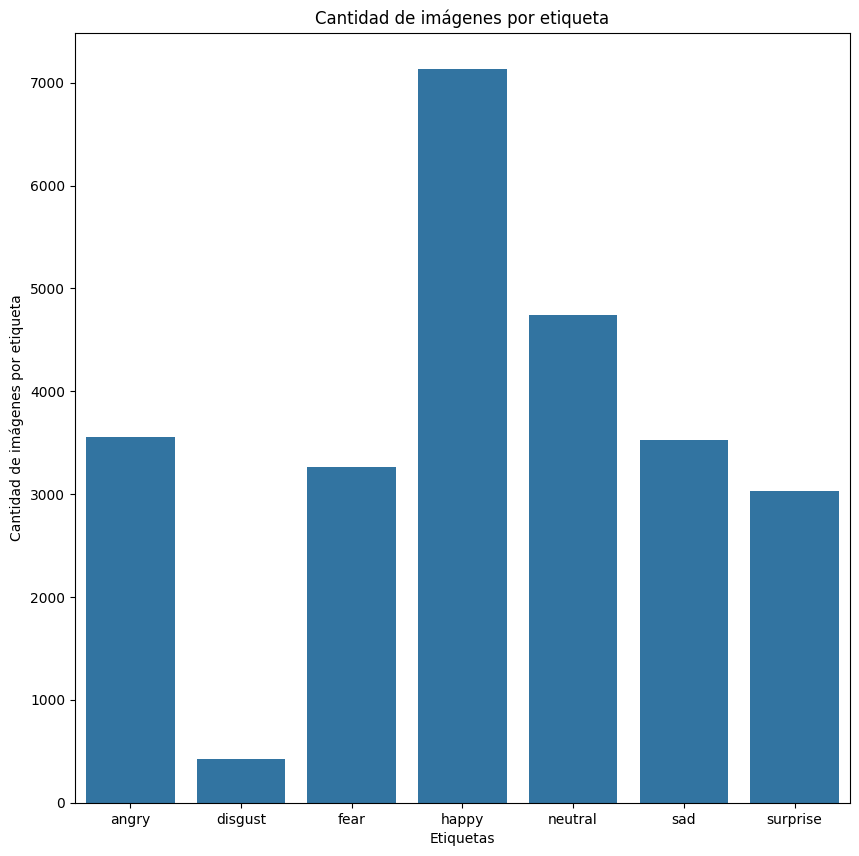

In [4]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.countplot(x='Etiquetas', data=df)
plt.xlabel('Etiquetas')
plt.ylabel('Cantidad de imágenes por etiqueta')
plt.title('Cantidad de imágenes por etiqueta')
plt.show()

In [5]:
distribucion = df['Etiquetas'].value_counts()
print(distribucion)

Etiquetas
happy       7130
neutral     4746
angry       3557
sad         3528
fear        3263
surprise    3032
disgust      429
Name: count, dtype: int64


In [7]:
num_objetivo = 429
df_balanceado = pd.DataFrame()

# Reducir 'happy' y 'neutral' a 3500 registros
for categoria in ['happy', 'neutral', 'sad', 'angry', 'surprise','fear']:
    df_categoria = df[df['Etiquetas'] == categoria]
    df_categoria = df_categoria.sample(n=num_objetivo, random_state=1, replace=False)  # Muestreo aleatorio sin reemplazo
    df_balanceado = pd.concat([df_balanceado, df_categoria])

# Mantener las otras categorías tal como están
for categoria in df['Etiquetas'].unique():
    if categoria not in ['happy', 'neutral', 'sad', 'angry', 'surprise','fear']:
        df_categoria = df[df['Etiquetas'] == categoria]
        df_balanceado = pd.concat([df_balanceado, df_categoria])

# Verificar la nueva distribución de etiquetas
print(df_balanceado['Etiquetas'].value_counts())


Etiquetas
happy       429
neutral     429
sad         429
angry       429
surprise    429
fear        429
disgust     429
Name: count, dtype: int64


In [8]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_balanceado['Etiquetas'])

In [9]:
x = np.array(df_balanceado['Hitos faciales'].tolist())

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,stratify=y, random_state=42)

In [17]:
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2

# Definir la entrada del modelo
inputs = Input(shape=(144, 2))

# Aplanar los datos de entrada
flatten = Flatten()(inputs)

# Capas densas

dense8 = Dense(600, activation='relu')(flatten)
dense9 = Dense(300, activation='relu')(dense8)
dense10 = Dense(150, activation='relu')(dense9)
dense11 = Dense(64, activation='relu')(dense10)
dense12 = Dense(32, activation='relu')(dense11)
#dense13 = Dense(32, activation='relu')(dense12)


# Capa de salida
outputs = Dense(len(label_encoder.classes_), activation='softmax')(dense12)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.95:
            print("\nReached 60% accuracy so cancelling training!")
            self.model.stop_training = True
            
back = myCallback() 

In [18]:
model.fit(X_train, y_train, epochs=150, batch_size=32)

Epoch 1/150
66/66 [==============================] - 1s 6ms/step - loss: 6.2535 - accuracy: 0.1437
Epoch 2/150
66/66 [==============================] - 0s 4ms/step - loss: 2.3554 - accuracy: 0.1698
Epoch 3/150
66/66 [==============================] - 0s 5ms/step - loss: 2.0371 - accuracy: 0.1874
Epoch 4/150
66/66 [==============================] - 0s 5ms/step - loss: 2.0259 - accuracy: 0.2022
Epoch 5/150
66/66 [==============================] - 0s 5ms/step - loss: 1.9605 - accuracy: 0.2112
Epoch 6/150
66/66 [==============================] - 0s 5ms/step - loss: 1.9552 - accuracy: 0.2098
Epoch 7/150
66/66 [==============================] - 0s 4ms/step - loss: 1.9219 - accuracy: 0.2169
Epoch 8/150
66/66 [==============================] - 0s 4ms/step - loss: 1.8414 - accuracy: 0.2697
Epoch 9/150
66/66 [==============================] - 0s 4ms/step - loss: 1.9171 - accuracy: 0.2127
Epoch 10/150
66/66 [==============================] - 0s 4ms/step - loss: 1.8202 - accuracy: 0.2759
Epoch 11/

In [19]:
# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

29/29 [==============================] - 0s 3ms/step - loss: 1.7498 - accuracy: 0.4095
Loss: 1.749848484992981, Accuracy: 0.4095449447631836


In [20]:
model.save('7MLPFER.h5')